In [1]:
#Generate plot 3 showing the efect of moments on the temp distribution.

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
# #Chicago
# LAT        = 41.8781
# LON        = 360-87.6298
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
########## CONUS ############
#CONUS lat-lon
top = 50.0 # north lat
left = -124.7844079+360 # west long
right = -66.9513812+360 # east long
bottom =  24.7433195 # south lat
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Bengaluru/'
locn       = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

In [5]:
cluster

In [6]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
doy      = 211 # day_of_year
date     = 'Jul30'

In [7]:
#To reduce communication between workers, I am manually fusing tasks
#dask.optimization.fuse(ave_width=50)

In [8]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 1.55 s, sys: 259 ms, total: 1.81 s
Wall time: 15.9 s


In [9]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX.sel(method='nearest',time=ds_ssp.time.dt.dayofyear==doy)
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(method='nearest',time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX.sel(method='nearest',time=ds_hist.time.dt.dayofyear==doy)
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgw

CPU times: user 355 ms, sys: 6.17 ms, total: 362 ms
Wall time: 386 ms


,Array,Chunk
Bytes,1.77 GiB,2.11 MiB
Shape,"(86, 192, 288, 100)","(10, 192, 288, 1)"
Count,1801 Tasks,900 Chunks
Type,float32,numpy.ndarray


In [10]:
%%time
#Get alll of the model warming data( historical and future) in one dataset.
modelgw_path = cvals+'tgmw'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(modelgw_path)
tgmw         = xr.concat([tghw,tgw],dim='time')
#tgmw         = tgmw.chunk({'time':10,'member':40,'lat':50,'lon':40})
tgmw         = tgmw.chunk({'time':100,'lat':40,'lon':60})
tgmw
#tgmw.to_dataset().to_zarr(modelgw_path,mode='w')
# #####
# tgmw         = xr.open_mfdataset(modelgw_path,engine='zarr')
# tgmw         = tgmw.TREFHTMX
# #tmw.sel(time='18500730').values

/global/scratch/users/harsha/LENS/cesm2/cvals/tgmwJul30_1850_2100.zarr
CPU times: user 162 ms, sys: 4.73 ms, total: 167 ms
Wall time: 163 ms


,Array,Chunk
Bytes,5.17 GiB,0.92 MiB
Shape,"(251, 192, 288, 100)","(100, 40, 60, 1)"
Count,23302 Tasks,7500 Chunks
Type,float32,numpy.ndarray


In [11]:
%%time
#Stack member and tinme into one dimension- 'tm'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
tgmw_stack     = tgmw.stack(tm=('time','member'),create_index=False)
N_mem          = 100
window_len     = 30
tgmw_construct = tgmw_stack.rolling(tm=N_mem*window_len, center=True).construct('index', stride=N_mem)
tgmw_construct

CPU times: user 202 ms, sys: 2.54 ms, total: 205 ms
Wall time: 253 ms


,Array,Chunk
Bytes,155.11 GiB,823.97 MiB
Shape,"(192, 288, 251, 3000)","(40, 60, 30, 3000)"
Count,61203 Tasks,225 Chunks
Type,float32,numpy.ndarray


In [12]:
%%time
#Check which values are nans
#tgmw_construct.isel(tm=1,lat=0,lon=0).sel(index=slice(1400,1600)).values

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [13]:
%%time
#tgmw_construct.encoding['chunks']
# tgmw_construct_nandrop   = tgmw_construct.dropna(dim='tm',how='any')
# tgmw_construct_nandrop
tgmw_construct_nandrop           = tgmw_construct.sel(tm=slice(15,251-14))
tgmw_construct_nandrop           = tgmw_construct_nandrop.chunk({'tm':30})
tgmw_construct_nandrop

CPU times: user 9.15 ms, sys: 147 µs, total: 9.29 ms
Wall time: 9.09 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, tm: 222, index: 3000)>
dask.array<rechunk-merge, shape=(192, 288, 222, 3000), dtype=float32, chunksize=(40, 60, 30, 3000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (tm) int64 dask.array<chunksize=(30,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(30,), meta=np.ndarray>
Dimensions without coordinates: tm, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [14]:
tgmw_construct_nandrop.sel(lat=LAT,lon=LON,method='nearest').sel(tm=1).values

array([301.22897, 299.03735, 299.43488, ..., 298.8593 , 298.4306 ,
       299.4545 ], dtype=float32)

In [15]:
%%time
# #Save tgmw_construct
#tgmw_construct_nandrop = tgmw_construct_nandrop.chunk({'lat':40,'tm':30})
#tgmw_rpath             = cvals+'tgmw_rolled'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
tgmw_r2path            = cvals+'tgmw_rolled_nonan'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
#tgmw_construct.to_dataset().to_zarr(tgmw_rpath,mode='w')
#tgmw_construct_nandrop.to_dataset().to_zarr(tgmw_r2path,mode='w')

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 15 µs


In [16]:
%%time
tgmw_construct_nandrop       = xr.open_zarr(tgmw_r2path)
tgmw_construct_nandrop       = tgmw_construct_nandrop.TREFHTMX
#tgmw_construct_nandrop['tm'] = tgmw_construct_nandrop['tm']+1865
tgmw_construct_nandrop  

CPU times: user 66.6 ms, sys: 10.9 ms, total: 77.5 ms
Wall time: 102 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, tm: 222, index: 3000)>
dask.array<open_dataset-d6bb93631f8d2e6919247f07300505e9TREFHTMX, shape=(192, 288, 222, 3000), dtype=float32, chunksize=(40, 60, 30, 3000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
Dimensions without coordinates: tm, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [17]:
tmw = tgmw_construct_nandrop.sel(lat=LAT,lon=LON,method='nearest')
tmw.sel(tm=1).values

array([301.22897, 299.03735, 299.43488, ..., 298.8593 , 298.4306 ,
       299.4545 ], dtype=float32)

In [18]:
%%time
#Compute quantiles 
quants    = np.arange(0,1.01,0.01)
qgmw      = tgmw_construct_nandrop.quantile(quants,dim='index',skipna=False)
qgmw

CPU times: user 6.34 ms, sys: 14 µs, total: 6.35 ms
Wall time: 5.99 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, tm: 222)>
dask.array<transpose, shape=(101, 192, 288, 222), dtype=float64, chunksize=(101, 40, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time      (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Dimensions without coordinates: tm

In [19]:
%%time
qgmw_path  = cvals+'qgmw_percentiles'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# #qgmw.compute()
# qgmw.to_dataset().to_zarr(qgmw_path,mode='w')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [20]:
# %%time
# tgmw_construct_nandrop.mean().values

In [21]:
%%time
qgmw  = xr.open_mfdataset(qgmw_path,engine='zarr')
qgmw  = qgmw.TREFHTMX
qgmw  = qgmw.assign_coords({'tm':qgmw.tm + 1865})
qgmw

CPU times: user 14.1 ms, sys: 1.14 ms, total: 15.2 ms
Wall time: 72.4 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, tm: 222)>
dask.array<open_dataset-77e96ad9c90ecedb81ab84a3fccf4427TREFHTMX, shape=(101, 192, 288, 222), dtype=float64, chunksize=(101, 40, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    time      (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
  * tm        (tm) int64 1865 1866 1867 1868 1869 ... 2082 2083 2084 2085 2086

CPU times: user 283 ms, sys: 24.5 ms, total: 307 ms
Wall time: 1.12 s


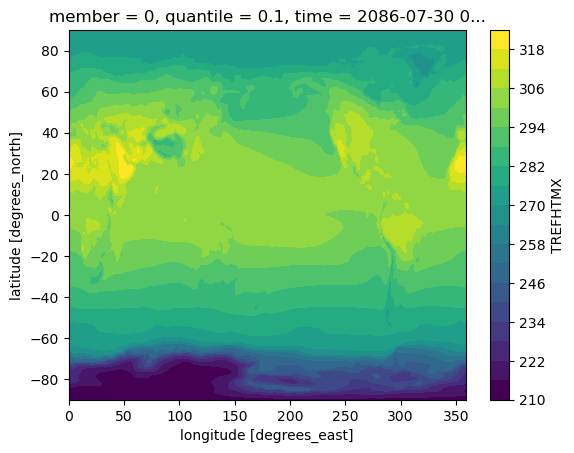

In [22]:
%%time 
qgmw.sel(quantile=0.1,tm = 2086).plot.contourf(levels=20)

In [23]:
# %%time
# qgmw_diff.sel(quantile=0.1).plot.contourf(levels=20)

In [24]:
tgmw_construct_nandrop

<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, tm: 222, index: 3000)>
dask.array<open_dataset-d6bb93631f8d2e6919247f07300505e9TREFHTMX, shape=(192, 288, 222, 3000), dtype=float32, chunksize=(40, 60, 30, 3000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
Dimensions without coordinates: tm, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [25]:
%%time
#Compute the pre-industrial + moments adjusted curve
#First compute rolling means and stdevs and save them
tgmw_mroll = tgmw_construct_nandrop.mean(dim='index')
tgmw_sroll = tgmw_construct_nandrop.std(dim='index')
#Paths 
tgmw_mrollpath = cvals+'tgmw_roll30yr_mean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
tgmw_srollpath = cvals+'tgmw_roll30yr_std'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
###########
# tgmw_mroll.to_dataset().to_zarr(tgmw_mrollpath,mode='w')
# tgmw_sroll.to_dataset().to_zarr(tgmw_srollpath,mode='w')
#############
tgmw_mroll

CPU times: user 8.44 ms, sys: 17 µs, total: 8.46 ms
Wall time: 8.29 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, tm: 222)>
dask.array<mean_agg-aggregate, shape=(192, 288, 222), dtype=float32, chunksize=(40, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
Dimensions without coordinates: tm

In [26]:
%%time
tgmw_mroll = xr.open_mfdataset(tgmw_mrollpath,engine='zarr')
tgmw_sroll = xr.open_mfdataset(tgmw_srollpath,engine='zarr')
tgmw_mroll = tgmw_mroll.TREFHTMX
tgmw_sroll = tgmw_sroll.TREFHTMX
tgmw_mroll

CPU times: user 22 ms, sys: 5.14 ms, total: 27.1 ms
Wall time: 94.5 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, tm: 222)>
dask.array<open_dataset-aa2693e7151291c9475414e9268d170fTREFHTMX, shape=(192, 288, 222), dtype=float32, chunksize=(40, 60, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
Dimensions without coordinates: tm

In [27]:
# #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
#tgnw = tgnw.rename({'time':'old_time'})
tgnw       = tgnw.chunk({'lat':40,'lon':60})
tgnw_stack = tgnw.stack(mtime=('member','time'),create_index=False)
tgnw_stack = tgnw_stack.expand_dims(dim={'tm':222}).\
               assign_coords(tm=('tm',np.arange(1865,2087)))
tgnw_stack

,Array,Chunk
Bytes,137.19 GiB,60.97 MiB
Shape,"(222, 192, 288, 3000)","(222, 40, 60, 30)"
Count,33701 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [28]:
tgmc      = (tgnw_stack - tgnw_stack.mean(dim='mtime'))+tgmw_mroll
tgmsc     = (tgnw_stack - tgnw_stack.mean(dim='mtime'))*(tgmw_sroll/tgnw_stack.std(dim='mtime'))\
             + tgmw_mroll
tgmc      = tgmc.chunk({'tm':30,'mtime':3000})
tgmsc     = tgmsc.chunk({'tm':30,'mtime':3000})
tgmsc

<xarray.DataArray 'TREFHTMX' (tm: 222, lat: 192, lon: 288, mtime: 3000)>
dask.array<rechunk-merge, shape=(222, 192, 288, 3000), dtype=float32, chunksize=(30, 40, 60, 3000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * tm       (tm) int64 1865 1866 1867 1868 1869 ... 2082 2083 2084 2085 2086
    member   (tm) int64 dask.array<chunksize=(30,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(30,), meta=np.ndarray>
Dimensions without coordinates: mtime

In [29]:
%%time
#Paths 
tgmc_path  = cvals+'tgmc0'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
tgmsc_path = cvals+'tgmsc0'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
######
# tgmc       = tgmc.chunk({'lat':30,'lon':50})
# tgmsc      = tgmsc.chunk({'lat':30,'lon':50})
# #Save files
# tgmc.to_dataset().to_zarr(tgmc_path,mode='w')
# tgmsc.to_dataset().to_zarr(tgmsc_path,mode='w')

CPU times: user 6min 36s, sys: 12.8 s, total: 6min 49s
Wall time: 15min 54s


In [30]:
#Open files
tgmc   = xr.open_mfdataset(tgmc_path,engine='zarr')
tgmsc  = xr.open_mfdataset(tgmsc_path,engine='zarr')
tgmc   = tgmc.TREFHTMX
tgmsc  = tgmsc.TREFHTMX

In [31]:
%%time
#Compute quantiles
qgmc     = tgmc.quantile(quants,dim='mtime',skipna=False)
qgmsc    = tgmsc.quantile(quants,dim='mtime',skipna=False)
qgmsc

CPU times: user 14.8 ms, sys: 2.04 ms, total: 16.9 ms
Wall time: 16.2 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, tm: 222, lat: 192, lon: 288)>
dask.array<transpose, shape=(101, 222, 192, 288), dtype=float64, chunksize=(101, 30, 40, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time      (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
  * tm        (tm) int64 1865 1866 1867 1868 1869 ... 2082 2083 2084 2085 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [32]:
%%time
#Save all quantile functions
qgmsc_path = cvals+'qgmsc_percentile'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_path  = cvals+'qgmc_percentile'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_path  = cvals+'qgmw'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(qgmsc_path)
# qgmc.to_dataset().to_zarr(qgmc_path,mode='w')
# #########
# qgmsc.to_dataset().to_zarr(qgmsc_path,mode='w')
# print(qgmc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/qgmsc_percentileJul30_1850_2100.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/qgmc_percentileJul30_1850_2100.zarr
CPU times: user 1min 33s, sys: 4 s, total: 1min 37s
Wall time: 11min 8s


In [33]:
%%time
qgmc  = xr.open_mfdataset(qgmc_path,engine='zarr')
qgmsc = xr.open_mfdataset(qgmsc_path,engine='zarr')
qgmc  = qgmc.TREFHTMX
qgmsc = qgmsc.TREFHTMX
qgmc

CPU times: user 30.6 ms, sys: 12.1 ms, total: 42.7 ms
Wall time: 38.8 ms


,Array,Chunk
Bytes,9.24 GiB,55.48 MiB
Shape,"(101, 222, 192, 288)","(101, 30, 40, 60)"
Count,201 Tasks,200 Chunks
Type,float64,numpy.ndarray


In [34]:
tmw

<xarray.DataArray 'TREFHTMX' (tm: 222, index: 3000)>
dask.array<getitem, shape=(222, 3000), dtype=float32, chunksize=(30, 3000), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
    member   (tm) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time     (tm) object dask.array<chunksize=(222,), meta=np.ndarray>
Dimensions without coordinates: tm, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

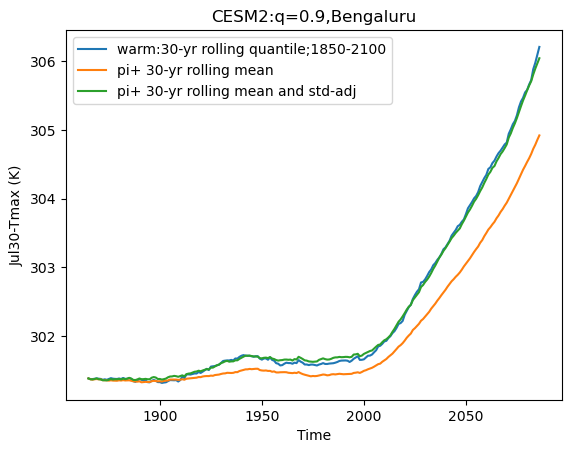

In [35]:
#Check if the results are reproduced for Bengaluru
year = np.arange(1865,2087)
qmw  = qgmw.sel(lat=LAT,lon=LON,method='nearest')
qmc  = qgmc.sel(lat=LAT,lon=LON,method='nearest')
qmsc = qgmsc.sel(lat=LAT,lon=LON,method='nearest')
plt.plot(year,qmw.sel(quantile=0.9),label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(year,qmc.sel(quantile=0.9),label='pi+ 30-yr rolling mean')
plt.plot(year,qmsc.sel(quantile=0.9),label='pi+ 30-yr rolling mean and std-adj')
plt.legend(loc='upper left')
plt.title('CESM2:q=0.9,'+locn)
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Time')
plt.show()

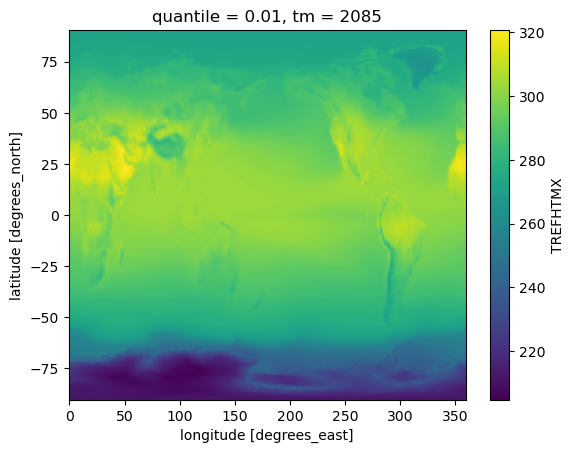

In [36]:
qgmc.sel(quantile=0.01,tm=2085).plot()

In [38]:
%%time
qgmw_diff  = qgmw.sel(tm=2085) - qgmw.sel(tm=1865)
qgmc_diff  = qgmc.sel(tm=2085) - qgmc.sel(tm=1865)
qgmsc_diff = qgmsc.sel(tm=2085) - qgmsc.sel(tm=1865)

CPU times: user 241 ms, sys: 5.09 ms, total: 246 ms
Wall time: 624 ms


In [39]:
qgmw_reldiff1 = qgmw_diff -qgmc_diff
qgmw_reldiff2 = qgmw_diff -qgmsc_diff

In [40]:
#Now, let us compute the relative changes 1) qgmw_diff -0 2) qgmw_diff -qgmc_diff 3) qgmw_diff - qgmsc_diff

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_string

CPU times: user 3.49 s, sys: 164 ms, total: 3.66 s
Wall time: 14.4 s


Text(0.5, 1.0, 'q=0.1,$\\delta t_w - 0$')

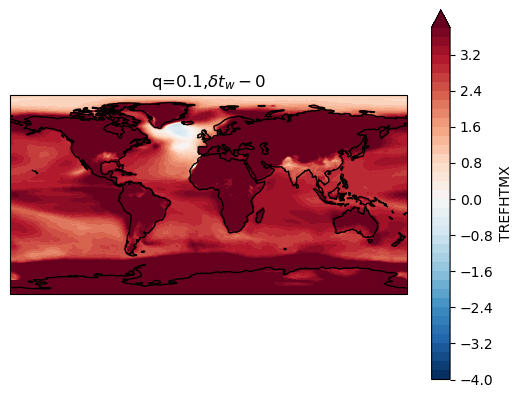

In [41]:
%%time
#Quantile q=0.1
#Plot 3a
levs    = np.arange(-4,4,0.2)
ax       = plt.axes(projection=cart.crs.PlateCarree())
qgmw_diff.sel(quantile=0.1).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.1,'+r'$\delta t_w - 0$')

CPU times: user 4.27 s, sys: 220 ms, total: 4.49 s
Wall time: 5.18 s


Text(0.5, 1.0, 'q=0.1,$\\delta t_w - \\delta t_{mc}$')

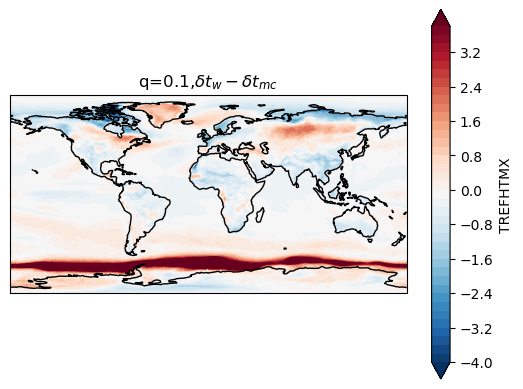

In [42]:
%%time
#PLot 3b
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_reldiff1.sel(quantile=0.1).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.1,'+r'$\delta t_w - \delta t_{mc}$')

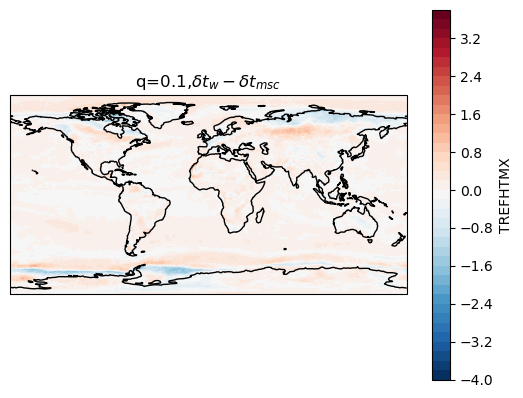

CPU times: user 10.9 s, sys: 823 ms, total: 11.7 s
Wall time: 11.9 s


In [44]:
%%time
#PLot 3c
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmw_reldiff2.sel(quantile=0.1).plot.contourf(ax=ax,transform=cart.crs.PlateCarree(),levels=levs)
ax.coastlines(color="black")
plt.title('q=0.1,'+r'$\delta t_w - \delta t_{msc}$')
plt.show()

In [45]:
############# Compute area-weighted mean square of the above errors #####################

In [46]:
qgmw_error_square  = qgmw_diff**2
qgmc_error_square  = qgmw_reldiff1**2
qgmsc_error_square = qgmw_reldiff2**2

In [47]:
weights      = np.cos(np.deg2rad(qgmw_error_square.lat))
weights.name = "weights"
#weights

In [48]:
qgmw_serror_weighted  = qgmw_error_square.weighted(weights)
qgmc_serror_weighted  = qgmc_error_square.weighted(weights)
qgmsc_serror_weighted = qgmsc_error_square.weighted(weights)
qgmc_serror_weighted

DataArrayWeighted with weights along dimensions: lat

In [49]:
%%time
qgmw_serror_gmean   = qgmw_serror_weighted.mean({'lat','lon'})
qgmc_serror_gmean   = qgmc_serror_weighted.mean({'lat','lon'})
qgmsc_serror_gmean  = qgmsc_serror_weighted.mean({'lat','lon'})
qgmc_serror_gmean

CPU times: user 69.4 ms, sys: 1.11 ms, total: 70.5 ms
Wall time: 73.7 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<truediv, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [50]:
%%time
#p= percentile
qgmw_gmeanpath  = cvals+'qgmw_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_gmeanpath  = cvals+'qgmc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_gmeanpath = cvals+'qgmsc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmw_serror_gmean.to_dataset().to_zarr(qgmw_gmeanpath,mode='w')
# qgmc_serror_gmean.to_dataset().to_zarr(qgmc_gmeanpath,mode='w')
# qgmsc_serror_gmean.to_dataset().to_zarr(qgmsc_gmeanpath,mode='w')

CPU times: user 1.91 s, sys: 160 ms, total: 2.07 s
Wall time: 5.01 s


In [51]:
qgmc_serror_gmean.values

array([5.42951825, 2.77489906, 2.35454933, 2.09574232, 1.89964672,
       1.74364628, 1.61225431, 1.4979843 , 1.39433606, 1.30174713,
       1.21826467, 1.14059085, 1.069211  , 1.00217888, 0.93868927,
       0.88022892, 0.82534449, 0.7733275 , 0.72373047, 0.67791343,
       0.63424339, 0.59285364, 0.55253207, 0.51397227, 0.47721686,
       0.44294601, 0.41097834, 0.38045165, 0.35155772, 0.32502217,
       0.30011445, 0.27695786, 0.25507538, 0.23487901, 0.21619542,
       0.19879473, 0.18285827, 0.16845733, 0.1558435 , 0.14431321,
       0.13434971, 0.1252524 , 0.117424  , 0.11123864, 0.10620356,
       0.10243065, 0.09965627, 0.09815503, 0.09751276, 0.09818254,
       0.09979006, 0.10249665, 0.10630132, 0.11099481, 0.11653937,
       0.12327437, 0.13092142, 0.13965036, 0.14914197, 0.15960041,
       0.17111417, 0.183158  , 0.19620553, 0.21018308, 0.22517769,
       0.24083914, 0.25758583, 0.27527141, 0.29365789, 0.31291838,
       0.33351742, 0.35470519, 0.37682454, 0.39995723, 0.42402

In [52]:
%%time
qgmw_serror_gmean  = xr.open_zarr(qgmw_gmeanpath)
qgmc_serror_gmean  = xr.open_zarr(qgmc_gmeanpath)
qgmsc_serror_gmean = xr.open_zarr(qgmsc_gmeanpath)
qgmw_serror_gmean  = qgmw_serror_gmean.TREFHTMX
qgmc_serror_gmean  = qgmc_serror_gmean.TREFHTMX
qgmsc_serror_gmean = qgmsc_serror_gmean.TREFHTMX
qgmw_grmse         = np.sqrt(qgmw_serror_gmean)
qgmc_grmse         = np.sqrt(qgmc_serror_gmean)
qgmsc_grmse        = np.sqrt(qgmsc_serror_gmean)

CPU times: user 12 ms, sys: 3.06 ms, total: 15 ms
Wall time: 15.2 ms


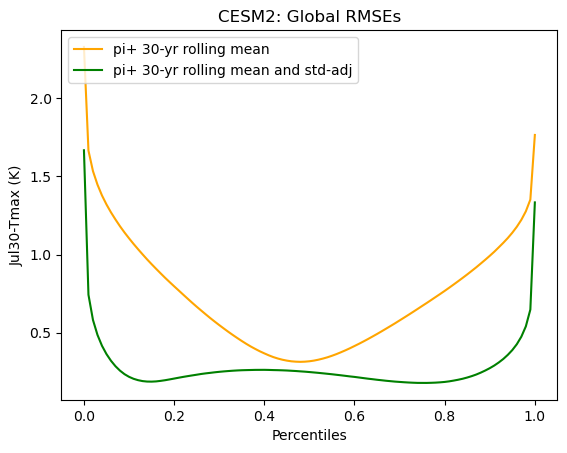

CPU times: user 207 ms, sys: 18.3 ms, total: 226 ms
Wall time: 264 ms


In [53]:
%%time
#plt.plot(quants,qgmw_serror_gmean,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global RMSEs')
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Percentiles')
plt.show()

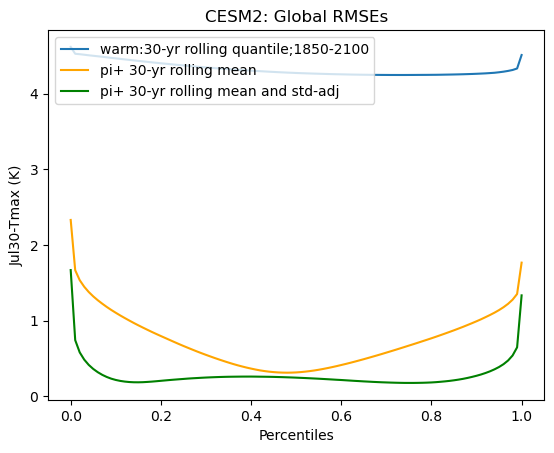

CPU times: user 620 ms, sys: 57.3 ms, total: 677 ms
Wall time: 765 ms


In [54]:
%%time
plt.plot(quants,qgmw_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global RMSEs')
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Percentiles')
plt.show()